# Intro to Variational Autoencoders (VAEs)

Adapted from Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)

<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">0. Imports & installs</h2>

In [5]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">1. Download the MNIST data</h2>

In [6]:
dataset_path = './data/' # feel free to change this! 

In [7]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

batch_size = 100

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100.0%
100.0%
100.0%
100.0%


<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">2. Set your hyperparameters</h2>

In [ ]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

x_dim  = 784
hidden_dim = 400
# latent_dim = 200
latent_dim = 20

lr = 1e-3
epochs = 30

<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">3. Define the VAE model</h2>

In [10]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer1 = nn.Linear(input_dim, hidden_dim) # linear layer from input_dim -> hidden_dim 
        self.layer2 = nn.Linear(hidden_dim, hidden_dim) # linear layer from hidden_dim -> hidden_dim 
        self.mu     = nn.Linear(hidden_dim, latent_dim) # linear layer from hidden_dim -> latent_dim 
        self.sigma  = nn.Linear(hidden_dim, latent_dim) # linear layer from hidden_dim -> latent_dim 

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h       = self.LeakyReLU(self.layer1(x)) # apply layer1 to input x
        h       = self.LeakyReLU(self.layer2(h)) # apply layer1 to h
        mean    = self.mu(h) # apply the relevant layer to h
        log_var = self.sigma(h) # apply the relevant layer to h
        
        return mean, log_var

In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.layer1 = nn.Linear(latent_dim, hidden_dim) # linear layer from latent_dim -> hidden_dim 
        self.layer2 = nn.Linear(hidden_dim, hidden_dim) # linear layer from hidden dim -> hidden_dim 
        self.output_layer = nn.Linear(hidden_dim, output_dim) # linear layer from hidden dim -> output_dim
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.layer1(x)) # apply layer1 to input x
        h     = self.LeakyReLU(self.layer2(h)) # apply layer2 to h
        
        x_hat = torch.sigmoid(self.output_layer(h)) # apply output_layer
        return x_hat
        

In [18]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [19]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">4. Define the loss function</h2>

In [20]:
from torch.optim import Adam

BCE_loss = nn.BCELoss() 

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">5. Train!</h2>

In [21]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.28268874230488
	Epoch 2 complete! 	Average Loss:  129.20558755151816
	Epoch 3 complete! 	Average Loss:  116.59613341571891
	Epoch 4 complete! 	Average Loss:  112.36994140625
	Epoch 5 complete! 	Average Loss:  110.06493005921327
	Epoch 6 complete! 	Average Loss:  108.39576584346307
	Epoch 7 complete! 	Average Loss:  107.10555157032555
	Epoch 8 complete! 	Average Loss:  106.04682778589316
	Epoch 9 complete! 	Average Loss:  105.30438474932178
	Epoch 10 complete! 	Average Loss:  104.67809066543197
	Epoch 11 complete! 	Average Loss:  104.2648464889399
	Epoch 12 complete! 	Average Loss:  103.74653791475376
	Epoch 13 complete! 	Average Loss:  103.36184818121347
	Epoch 14 complete! 	Average Loss:  103.03007742396181
	Epoch 15 complete! 	Average Loss:  102.67635734035893
	Epoch 16 complete! 	Average Loss:  102.44707045922893
	Epoch 17 complete! 	Average Loss:  102.18620919305613
	Epoch 18 complete! 	Average Loss:  101.93165697712332
	

<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">6. Generate images</h2>

In [22]:
import matplotlib.pyplot as plt

In [23]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [24]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

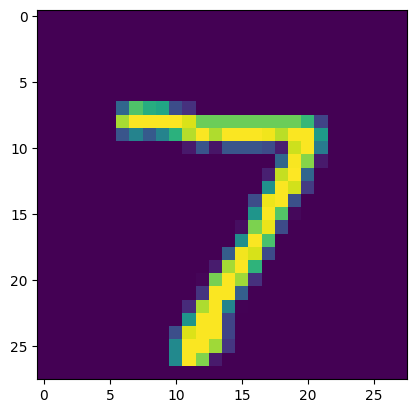

In [25]:
show_image(x, idx=0)

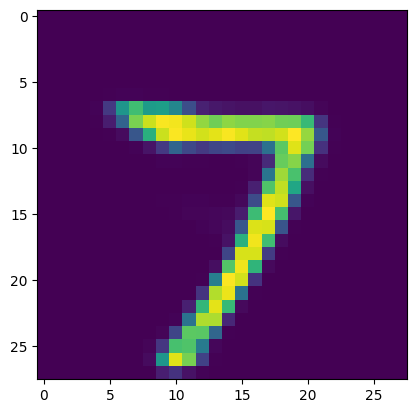

In [26]:
show_image(x_hat, idx=0)

<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">7. Generate new images</h2>

In [27]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [28]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

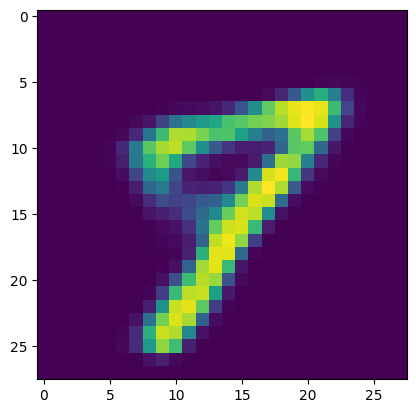

In [29]:
show_image(generated_images, idx=12)

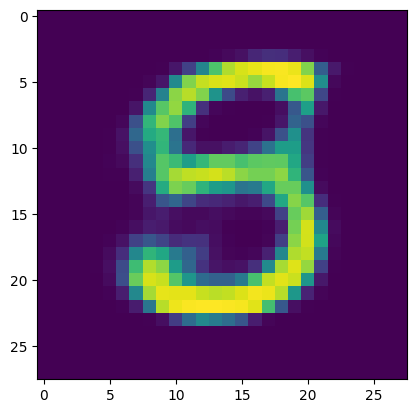

In [30]:
show_image(generated_images, idx=0)